# About RBMs

Let us assume we have $d$ visible units and $n$ hidden units.


Energy of an RBM

$$
E(\pmb{x},\pmb{h}) = - \pmb{c}^T \pmb{v} - \pmb{b}^T \pmb{h} - \pmb{h}^T \pmb{W} \pmb{v}
$$

Probability of an assignment of hidden and visible units:

$$
P(v,h) = - \frac{ e^{-E(v,h)} } { \sum_{( \bar{v},\bar{h}) \in \{0,1\}^d x \{0,1\}^n } e^{-E(\bar{v},\bar{h})} }
$$

In [1]:
import sys
import os
import inspect
#sys.path.insert(0,'..')

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent =  os.path.dirname(currentdir) + '/RBM'
sys.path.insert(0,parent)

%load_ext autoreload
%autoreload 2
%matplotlib inline

from timeit import default_timer as timer
import numpy as np
import time
import matplotlib.pyplot as plt
import numexpr  as ne
import profile
import rbm as Rbm
import pandas

## Read the MNIST 

In [2]:
X_ = pandas.read_csv("../Datasets/MNIST/train_mnist.csv")
Y = X_["label"].values
X = X_[X_.columns[1:]].values

del(X_)

print('\t files read')
X = np.array(X>4, dtype ='float32')

saved_models_folder = "saved_models"
visible_dim = X.shape[1]
hidden_dim = 225
epochs = 100
K = 1
lr = 0.1
batch_size = 10

Xaux = np.array(X, dtype='float32')

	 files read


## Define an RBM and train it


In [3]:
rbm_ = Rbm.RBM(visible_dim=visible_dim,
               hidden_dim=hidden_dim,
               seed=42,
               mu=0, 
               sigma=0.3,
               monitor_time=True)

In [4]:
rbm_.W.shape, rbm_.b.shape, rbm_

((784, 225), (784,), <rbm.RBM at 0x110a263c8>)

### Training multiple epochs and showing the weights

In [7]:
rbm_ = Rbm.RBM(visible_dim=visible_dim,
               hidden_dim=hidden_dim,
               seed=42,
               mu=0, 
               sigma=0.3,
               monitor_time=True)

In [8]:
%%time
rbm_.fit(Xaux, 
         method='vectorized_CDK',
         K=K,
         lr=0.01,
         epochs=200,
         batch_size=128,
         plot_weights=False)

	Last epoch: 199 	time per epoch: 2.30	total time: 474.88
	Training finished


CPU times: user 12min 49s, sys: 2min 5s, total: 14min 55s
Wall time: 7min 54s


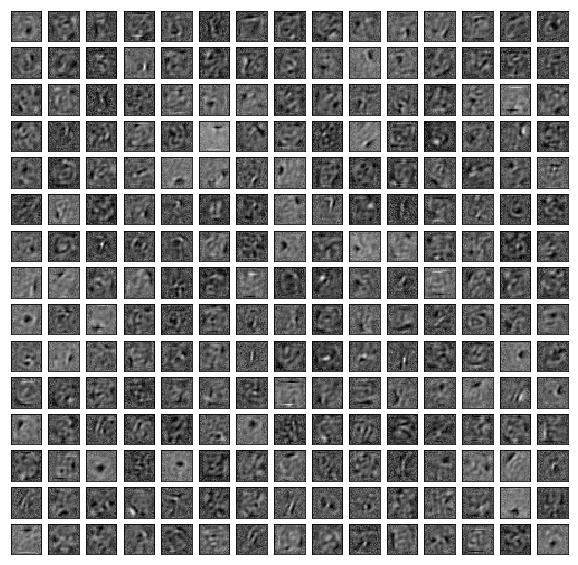

In [10]:
rbm_.plot_weights(min_max_scale = True)

#### Saving the model with joblib

In [11]:
import joblib

# save the classifier
#joblib.dump(rbm_, filename="./saved_models/rbm.pkl")    

# load it again
#rbm2 = joblib.load("./saved_models/rbm.pkl")

In [12]:
#plt.imshow(rbm2.W[:,3].reshape(28,28), cmap="gray")

### Using the model as a feature generation machine

In [13]:
import sklearn
from sklearn import ensemble
from sklearn import linear_model
import pandas
import numpy as np

In [14]:
X_ = pandas.read_csv("../Datasets/MNIST/train_mnist.csv")
Y = X_["label"].values
X = X_[X_.columns[1:]].values

In [15]:
model = sklearn.linear_model.Perceptron(max_iter = 50)
model.fit(X,Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=50, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [17]:
print("train accuracy:",np.mean(Y==model.predict(X)))

train accuracy: 0.889904761905


#### Learn perceptron on top of Features given by the RBM

In [27]:
X_features_rbm = rbm_.propup(X)

In [28]:
model = sklearn.linear_model.Perceptron(max_iter = 50)
model.fit(X_features_rbm ,Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=50, n_iter=None, n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [30]:
print("train accuracy:",np.mean(Y==model.predict(X_features_rbm )))

train accuracy: 0.922047619048


# Finding similar examples to a query example

We will do two experiments.

- Find the closest examples to a query in the original representation of size 784
- Find the closest examples to a query in the hidden representation of size `num_hidden_units`


In [15]:
Y[19]

5

In [ ]:
# take an example within the dataset
query = Xaux[19]
plt.imshow(query.reshape(28,28), cmap="gray")

7Now we will define a function that given a query and a dataset where to find it
retrieves the instances closest to que query.


In [ ]:
# find the closest examples to que query using the original representation
def find_similar(X,query,num_retrieved=10):
    dif = (X - query)
    distances = np.linalg.norm(dif,axis=1)
    closest_to_query = distances.argsort()
    distances.sort()
    return closest_to_query[1:num_retrieved+1], distances[1:num_retrieved+1]

In [ ]:
def plot_images(X, distances):
    num_elements = len(X)
    min_max_scale=True
    plt.figure( figsize=(num_elements*2.5,num_elements))

    for i, x in enumerate(X):
        plt.subplot(1,num_elements, i+1)
        plt.imshow(x, cmap=plt.get_cmap('gray'))
        plt.xlabel("dist to query " + str(distances[i]),rotation='horizontal')
        
        plt.xticks(())
        plt.yticks(())

## Looking for similar images in the original representation

In [ ]:
similar_patterns_indicies,distances = find_similar(X, query, num_retrieved=20)
similar_patterns = X[similar_patterns_indicies]
similar_patterns_as_matrices = [ x.reshape(28,28) for x in similar_patterns]
plot_images(similar_patterns_as_matrices, distances)

### Look that the 20 closest examples

In [ ]:
similar_patterns_indicies,distances = find_similar(X, query, num_retrieved=20)
X_similar = X[similar_patterns_indicies] 
closest_classes = Y[similar_patterns_indicies]
np.unique(closest_classes, return_counts=True)

In [ ]:
error_indicies = Y[similar_patterns_indicies] != 0
error_examples = [x.reshape(28,28) for x in X_similar[error_indicies]]
plot_images(error_examples, distances)

## Looking for similar images in the hidden representation

In [ ]:
hidden_query = rbm_.propup(query)
hidden_X = rbm_.propup(X)

similar_patterns_indicies, hidden_distances = find_similar(hidden_X, hidden_query, num_retrieved=20)
similar_patterns = X[similar_patterns_indicies]
similar_patterns_as_matrices = [ x.reshape(28,28) for x in similar_patterns]
similar_patterns_as_matrices[0].shape
plot_images(similar_patterns_as_matrices, hidden_distances)

### Look that the 500 closest examples

In [ ]:
similar_patterns_indicies, distances = find_similar(hidden_X, hidden_query, num_retrieved=500)
X_similar = X[similar_patterns_indicies] 
closest_classes = Y[similar_patterns_indicies]
np.unique(closest_classes, return_counts=True)

In [ ]:
error_indicies = Y[similar_patterns_indicies] != 0
error_examples = [x.reshape(28,28) for x in X_similar[error_indicies]]
plot_images(error_examples, distances)

# Plot the weights after training

### Plot the incoming weight to hidden unit j with "plot_weight"

In [ ]:
rbm.plot_weight(3)

### Plot the weights of all hidden units with ".plot_weights"

In [ ]:
rbm.plot_weights(min_max_scale = True)

In [ ]:
rbm.plot_weights(min_max_scale = False)

# Compute the probability of a visible vector  

To compute the probability of a visible vector $\pmb{x}$ you have to marginalize over the hidden states of the RBM. That is

$$
P(\pmb{x}) = \sum_{ \pmb{h} \in \mathcal{H}} P(\pmb{x}, \pmb{h}) 
$$

This exact inference method might be impractible if the number of elements in $ \mathcal{H}$ is too big.

Notice that $2^{20}=1048576$ is already a big number.  $2^{100}$ is an impracticable number for computing the exact probability of a visible vector even though 100 hidden units is a rather small number of units compared to a MLP.

In [ ]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent =  os.path.dirname(currentdir) + '/RBM'
sys.path.insert(0,parent)

# Load the data
X_ = pandas.read_csv("../Datasets/MNIST/train_mnist.csv")
Y = X_["label"].values
X = X_[X_.columns[1:]].values

del(X_)
print('\t files read')
X = np.array(X>4, dtype ='float32')


# Info about the model
saved_models_folder = "saved_models"
visible_dim = X.shape[1]
hidden_dim = 12
epochs = 100
K = 1
lr = 0.1
batch_size = 500
Xaux = np.array(X, dtype='float32')

rbm = joblib.load("./saved_models/rbm.pkl")

In [ ]:
print(rbm_.W.shape)
print(rbm_.b.shape)

In order to compute the probability of a visible vector we should compute:

$$
P(\pmb{x}) = \sum_{ \pmb{h} \in \mathcal{H}} P(\pmb{x}, \pmb{h}) = - \sum_{ \pmb{h} \in \mathcal{H}} \frac{ e^{-E(\pmb{x},\pmb{h})} } {Z }
$$

The denominator of the previous equation is constant. Since it does not depend on the presented input vector $\pmb{x}$ we just need to compute it once. This term is also called the partition function $Z$
 $$
 Z = \sum_{( \bar{\pmb{x}},\bar{\pmb{h}}) \in \{0,1\}^d x \{0,1\}^n } e^{-E(\bar{\pmb{x}},\bar{\pmb{h}})} 
 $$

Notice that the sum is over $2^d \cdot 2^n$ terms. Since d=784 in the MNIST case this is an impracticable thing to compute since a for loop over $2^{784} \cdot 2^{12}$ states is impracticable.

This is not the end of the story though. It turns out that this quantity can be computed with complexity determined by the minimum between the number of input units and the number of hidden units. If both quantities are above a reasonably big number, for example 100 , then more than $2^{100}$ computations will not be posible.

#### More efficient expression of $P(\pmb{x})$

**Proposition**
**Asume we have an RBM with `d` visible units and `n` hidden units then **

$$
P(\pmb{x}) = \sum_{ \pmb{h} \in \mathcal{H}} P(\pmb{x}, \pmb{h}) =  \sum_{ \pmb{h} \in \mathcal{H}}  \frac{e^{-E(\pmb{x}, \pmb{h})}}{Z} = \frac{ e^{\pmb{c}^T \pmb{x} + \sum_{j=1}^n \log( 1 + e^{b_j + \pmb{W}_{j \cdot }\pmb{x} }  ) }}{Z}
$$

To make the notation less confusing we can write $e^\alpha$ as $\exp(\alpha)$. Using this notation the previous result states
$$
P(\pmb{x}) = \frac{ \exp(-E(\pmb{x}, \pmb{h}))}{Z} =
\frac{ \exp \big(\pmb{c}^T \pmb{x} + \sum_{j=1}^n \log( 1 + \exp(b_j + \pmb{W}_{j \cdot }\pmb{x}) ) \big) }{Z}
$$

Some people writes this result using the "free energy" which is the term inside the exponential

$$
P(\pmb{x}) = \frac{\exp(-F(\pmb{x}))}{Z}
$$
**Demonstration**


\begin{equation}
\begin{split}
P(\pmb{x}) &= \sum_{ \pmb{h} \in \{0,1\}^n } P(\pmb{x}, \pmb{h}) & \\
  &= \frac{1}{Z} \sum_{ \pmb{h} \in \{0,1\}^n } \exp \Big( \pmb{c}^T  \pmb{x} +\pmb{b}^T \pmb{h} + \pmb{h}^T \pmb{W}\pmb{x}    \Big) \\
   &= \frac{1}{Z} \exp (\pmb{c}^T  \pmb{x}) \sum_{ \pmb{h} \in \{0,1\}^d } \exp \Big(  \sum_{j=1}^n b_j h_j + h_j \pmb{w}_{j \cdot}\pmb{x}    \Big) \\
   &= \frac{1}{Z} \exp (\pmb{c}^T  \pmb{x})  \sum_{ h_1 \in \{0,1\} } \sum_{ h_2 \in \{0,1\} } \dots \sum_{ h_n \in \{0,1\} } \exp \Big(  \sum_{j=1}^n b_j h_j + h_j \pmb{w}_{j \cdot}\pmb{x}    \Big) \\
   &\stackrel{(*)}{=} \frac{1}{Z} \exp (\pmb{c}^T  \pmb{x})  \Big(\sum_{ h_1 \in \{0,1\} }  \exp \Big(  b_1 h_1 + h_1 \pmb{w}_{1 \cdot}\pmb{x}    \Big) \Big) \dots  \Big(\sum_{ h_n \in \{0,1\}}\exp \Big(  b_n h_n + h_n \pmb{w}_{n \cdot}\pmb{x}    \Big) \Big)  \\
   &= \frac{1}{Z} \exp (\pmb{c}^T  \pmb{x})  \Big( 1 +  \exp (  b_1  +  \pmb{w}_{1 \cdot}\pmb{x} ) \Big) \dots  \Big( 1 +  \exp (  b_n  +  \pmb{w}_{n \cdot}\pmb{x} ) \Big)  \\
   &= \frac{1}{Z} \exp (\pmb{c}^T  \pmb{x}) \exp \Big( \log \Big( 1 +  \exp (  b_1  +  \pmb{w}_{1 \cdot}\pmb{x} ) \Big)\Big) \dots  \exp \Big( \log \Big( 1 +  \exp (  b_n  +  \pmb{w}_{n \cdot}\pmb{x} ) \Big)\Big)  \\
 &= \frac{1}{Z} \exp \Big( \pmb{c}^T  \pmb{x} + \sum_{j=1}^n \log \Big( 1 + \exp(b_j + \pmb{w}_{j \cdot} \pmb{x}) \Big) \Big)
 \\
 &= \frac{1}{Z} \exp \Big( \pmb{c}^T  \pmb{x} + \sum_{j=1}^n \text{softplus} ( b_j + \pmb{w}_{j \cdot} \pmb{x}) \Big)
 \end{split}
\end{equation}

Equality $(*)$ is the most relevant in the demonstration


### About the softplus function

Let's plot the softplus function. It turns out `softplus(x)` is similar to `max(x,0)`.

In [ ]:
import numpy as np
xvals = np.arange(-10., 10., 0.2)

def softplus(z):
    return np.log(1+ np.exp(z))

yvals = [softplus(x) for x in xvals]
yvals_relu = [max(x,0) for x in xvals]

plt.plot(xvals, yvals, linewidth=2)
plt.plot(xvals, yvals_relu, "--", linewidth=2)

We can think about each hidden unit as a feature.

The term $\sum_{j=1}^n \text{softplus} ( b_j + \pmb{w}_{j \cdot} \pmb{x})$ measures dependencies between the features in the input vector. If we want the previous sum to be big we need each term to be big (since all of them are positive). The $k$'th term will be big when the input vector is well aligned with $\pmb{w_{j \cdot}}$ that is, then the dot product $\pmb{w_{j \cdot}} \pmb{x}$ is big.


 A hidden unit $j$ can be interpreted as a feature from the input. The parameters $\pmb{w_{j \cdot}}$ (the incoming weights to unit $j$ ) control the importance of the $j$'th feature in the input. This importance value will depend on the bias $b_j$. For example if $b_j$ is -100 then the $\pmb{w_{j \cdot}} \pmb{x}$ will need to be at least 100 so that the `softplus` value increases the probability of $\pmb{x}$. If $\pmb{w_{j \cdot}} \pmb{x}$ is for example 95 then `sofplus(-100+95)= softplus(-5)` is very close to zero.

In [ ]:
softplus(-5)

# Compute the conditional probability of a visible vector  given a hidden vector


In a RBM the conditional probability $p( \pmb{h} | \pmb{x} ) $ and $p( \pmb{x} | \pmb{h} )$ factorize.

- All hidden units are conditionally independent given a visible vector

\begin{equation}
p( \pmb{h} | \pmb{x} ) = \prod_{j=1}^n p(h_j | \pmb{x}) 
\end{equation}


- All visible units are conditionally independent given a hidden vector

\begin{equation}
p( \pmb{x} | \pmb{h} ) = \prod_{i=1}^d p(h_i | \pmb{h}) 
\end{equation}

**Demonstration**:

We will demonstrate that $p( \pmb{h} | \pmb{x} )$ factorizes as a product. The other expresion is analogous (for symmetry).


\begin{equation}
\begin{split}
p( \pmb{h} | \pmb{x} ) &=  \frac{P(\pmb{x}, \pmb{h})}{\sum_{ \hat{\pmb{h}} \in \{0,1\}^n } P(\pmb{x}, \hat{\pmb{h}})} & \\
  &= \frac{ \exp \Big( \pmb{c}^T  \pmb{x} +\pmb{b}^T \pmb{h} + \pmb{h}^T \pmb{W}\pmb{x}    \Big) \big/z}{\sum_{ \hat{\pmb{h}} \in \{0,1\}^n } \exp \Big( \pmb{c}^T  \pmb{x} +\pmb{b}^T\pmb{\hat{h}}+ \pmb{\hat{h}}^T \pmb{W}\pmb{x}    \Big) \big/ z} & \\
  &= \frac{ \exp \Big(  \pmb{b}^T \pmb{h} + \pmb{h}^T \pmb{W}\pmb{x}    \Big) }{\sum_{ \hat{\pmb{h}} \in \{0,1\}^n } \exp \Big(  \pmb{b}^T \pmb{\hat{h}}+ \pmb{\hat{h}}^T \pmb{W}\pmb{x}    \Big) } & \\
&= \frac{ \exp \Big(  \sum_{j=1}^n b_j h_j + h_j \pmb{w}_{j \cdot}\pmb{x}    \Big) }{\sum_{ \hat{\pmb{h}} \in \{0,1\}^n } \exp \Big(  \pmb{b}^T \pmb{\hat{h}}+ \pmb{\hat{h}}^T \pmb{W}\pmb{x}    \Big) } & \\
&= \frac{  \prod_{j=1}^n \exp \Big(   b_j h_j + h_j \pmb{w}_{j \cdot}\pmb{x}    \Big) }{\sum_{ \hat{h_1} \in \{0,1\} } \dots \sum_{ \hat{h_n} \in \{0,1\} }  \exp \Big(  \sum_{j=1}^n b_j \hat{h}_j + \hat{h}_j \pmb{w}_{j \cdot}\pmb{x}     \Big) } & \\
&= \frac{  \prod_{j=1}^n \exp \Big(   b_j h_j + h_j \pmb{w}_{j \cdot}\pmb{x}    \Big) }{\sum_{ \hat{h_1} \in \{0,1\} } \dots \sum_{ \hat{h_n} \in \{0,1\} }   \prod_{j=1}^n  \exp \Big( b_j \hat{h}_j + \hat{h}_j \pmb{w}_{j \cdot}\pmb{x}     \Big) } & \\
&= \frac{  \prod_{j=1}^n \exp \Big(   b_j h_j + h_j \pmb{w}_{j \cdot}\pmb{x}    \Big) }{ \Big( \sum_{ \hat{h_1} \in \{0,1\} }  \exp \big( b_1 \hat{h}_1 + \hat{h}_1 \pmb{w}_{1 \cdot}\pmb{x} \big)  \Big) \dots \Big( \sum_{ \hat{h_n} \in \{0,1\} }   \exp \big( b_n \hat{h}_n + \hat{h}_n \pmb{w}_{n \cdot}\pmb{x}     \big) \Big) } & \\
&= \frac{  \prod_{j=1}^n \exp \Big(   b_j h_j + h_j \pmb{w}_{j \cdot}\pmb{x}    \Big) }{ \prod_{j=1}^n \sum_{ \hat{h_j} \in \{0,1\} }   \exp \big( b_j \hat{h}_j + \hat{h}_j \pmb{w}_{j \cdot}\pmb{x}     \big)   } & \\
&= \frac{  \prod_{j=1}^n \exp \Big(   b_j h_j + h_j \pmb{w}_{j \cdot}\pmb{x}    \Big) }{ \prod_{j=1}^n   \big(  1 +  \exp (b_j  + \pmb{w}_{j \cdot}\pmb{x} \big)     \Big)   } & \\
&=  \prod_{j=1}^n  \frac{ \exp \Big(   b_j h_j + h_j \pmb{w}_{j \cdot}\pmb{x}    \Big) }{  \big(  1 +  \exp (b_j  + \pmb{w}_{j \cdot}\pmb{x} )     \Big)   } & \\
&=  \prod_{j=1}^n p(h_j | \pmb{x}) & \\
\end{split}
 \end{equation}

## Probability of a hidden unit beeing 1 (or on) given a visible vector

Once we have proved that $p( \pmb{h} | \pmb{x} ) =  \prod_{j=1}^n p(h_j | \pmb{x}) $ we need an expression to compute the probability of a hidden unit given a visible vector.  

It turns out that the probability of a hidden unit $j$ beiing active given a visible vector $\pmb{x}$ is the sigmoid of the incoming signal to unit $j$. That is,

\begin{equation}
p( h_j=1 | \pmb{x} ) = \text{sigmoid}(b_j + \pmb{w}_{j \cdot} \pmb{x})
\end{equation}

**Demonstration:**
Using the last two lines from the previous demonstration and substituting $h_j$ to 1 we have 
\begin{equation}
\begin{split}
p( h_j = 1 | \pmb{x} ) &=  \frac{ \exp (   b_j +  \pmb{w}_{j \cdot}\pmb{x}  ) }{   1 +  \exp (b_j  + \pmb{w}_{j \cdot}\pmb{x} )      }  \\
&=  \frac{ 1 }{   \exp (-b_j  - \pmb{w}_{j \cdot}\pmb{x})        +  1}  \\
&=   \text{sigmoid}(b_j + \pmb{w}_{j \cdot} \pmb{x})  \\
\end{split}
 \end{equation}
 
## Probability of a visible unit beeing 1  (or on) given a  hidden vector

An analogous result is true for the visible units:
 
\begin{equation}
p( x_j | \pmb{h} ) = \text{sigmoid}(c_j + \pmb{w}_{j \cdot} \pmb{h})
\end{equation}





## Log likelihood gradient for the gibbs distribution


Let's derive an expression for the log likelihood.

First let's do it for a single training example $\pmb{x}^{(i)}$. Let's recall de definition of the likelihood for a single training example:

\begin{equation}
\log \mathcal{L}(\Theta \mid \pmb{x}^{(i)}) =\log p_{\text{model}}(\pmb{x}^{(i)} ; \Theta) =\log p(\pmb{x}^{(i)} ; \Theta) 
\end{equation}

The probability of our model has the following form

\begin{equation}
p(\pmb{x} ; \Theta) = \frac{1}{ Z(\Theta)} \tilde{p}( \pmb{x} ; \Theta)
\end{equation}

Therefore the logarithm of the probability defined by our model is:

\begin{equation}
\log ( p(\pmb{x} ; \Theta)) = \log \tilde{p}( \pmb{x} ; \Theta) - \log Z(\Theta)
\end{equation}

The gradient of the previous expression is 

\begin{equation}
\nabla_{\theta} \log p(\pmb{x} ; \Theta) = \nabla_{\theta} \log \tilde{p}( \pmb{x} ; \Theta) -\nabla_{\theta}  \log Z(\Theta)
\end{equation}

the first term is referered to as the positive phase and the second term the negative phase of learning.

## Log likelihod gradient for a single example for the RBM

Now let's use the expression of the probability that a RBM defines:


\begin{equation}
p(\pmb{x},\pmb{h}) = \frac{ \exp{(-E(\pmb{x},\pmb{h})}) } { \sum_{ (\bar{\pmb{x}},\bar{\pmb{h}}) } \exp({-E(\bar{\pmb{x}},\bar{\pmb{h}}) )} }
\end{equation}

Where the energy of the RBM is
\begin{equation}
E(\pmb{x},\pmb{h}) = - \pmb{c}^T \pmb{v} - \pmb{b}^T \pmb{h} - \pmb{h}^T \pmb{W} \pmb{v}
\end{equation}
 
 
The loglikelihood for a single example of an RBM is 
 
\begin{equation}
\log  p(\pmb{x}^{(i)} ; \Theta) = \log \tilde{p}( \pmb{x}^{(i)} ; \Theta) - \log Z(\Theta) =  \log \sum_{\pmb{h}} \exp(-E(\pmb{x}^{(i)},\pmb{h}))  - \log \sum_{\pmb{x},\pmb{h}} \exp(-E(\pmb{x},\pmb{h}))
\end{equation}

Let's compute the partial derivative of the loglikelihood (for a simple example) with respect to a parameter $\theta$:

\begin{equation}
\frac{\partial}{\partial \theta} p(\pmb{x}^{(i)} ; \Theta)= \frac{1}{\sum_{\pmb{h}} \exp(-E(\pmb{x}^{(i)},\pmb{h}))}\sum_{\pmb{h}} \exp(-E(\pmb{x}^{(i)},\pmb{h})) \big(-  \frac{\partial E(\pmb{x}^{(i)},\pmb{h}))}{\partial \theta} \big)   -  \frac{1}{ \sum_{\pmb{x},\pmb{h}} \exp(-E(\pmb{x},\pmb{h}))}\sum_{\pmb{x},\pmb{h}} \exp(-E(\pmb{x},\pmb{h})) \big(-  \frac{\partial E(\pmb{x},\pmb{h}))}{\partial \theta} \big)
 \end{equation}

The previous expression contains $p(\pmb{h} \mid \pmb{x}^{(i)})$ and $p(\pmb{x}, \pmb{h})$

Notice :

\begin{equation}
p(\pmb{h} \mid \pmb{x}) = \frac{p(\pmb{h}, \pmb{x})}{p(\pmb{x})} =  \frac{\exp(-E(\pmb{x},\pmb{h}))}{Z(\Theta)} \cdot  \frac{1}{ \sum_{\hat{\pmb{h}}} p(\hat{\pmb{h}} , \pmb{x})  } =  \frac{\exp(-E(\pmb{x},\pmb{h}))}{Z(\Theta)} \cdot  \frac{1}{ \sum_{ \hat{\pmb{h}}} \frac{\exp(-E(\pmb{x},\hat{\pmb{h}}))}{Z(\Theta)}  } = \frac{\exp(-E(\pmb{x},\pmb{h}))}{\sum_{\hat{\pmb{h}}}\exp(-E(\pmb{x},\hat{\pmb{h}}))   }
\end{equation}

The partial derivative with respect to a parameter of the probability asigned by the model to a training instance is:


\begin{equation}
 \frac{\partial}{\partial \theta}  p(\pmb{x}^{(i)} ; \Theta)=  \sum_{\pmb{h}} p(\pmb{h} \mid \pmb{x}^{(i)})(- \frac{\partial E(\pmb{x}^{(i)},\pmb{h}))}{\partial \theta}) -   \sum_{\pmb{x},\pmb{h}} p(\pmb{x},\pmb{h}) \big(-  \frac{\partial E(\pmb{x},\pmb{h}))}{\partial \theta} \big)
\end{equation}


**The previous expression tell us that the partial derivative of the probability of an example with respect to a parameter is que difference between two expectations. The expected value of $-E$  with respect to $p(\pmb{h} \mid \pmb{x}^{(i)})$ minus the expected value of  $-E$ with respect to $p(\pmb{h}, \pmb{x})$ **

## Maximizing the log likelihood using gradient ascent

Let's consider we want to maximise the loglikelihood cost

\begin{equation}
C =  \sum_{m=1}^M \log p(x ; \Theta) = \sum_{m=1}^M C_{x^{(m)}}
\end{equation}

We have seen the expression for the partial derivate of the cost for a given training example $C_{x^{(i)}} = \log p(\pmb{x}^{(i)} ; \Theta)$



\begin{equation}
 \frac{\partial}{\partial \theta}  p(\pmb{x}^{(i)} ; \Theta)=  \sum_{\pmb{h}} p(\pmb{h} \mid \pmb{x}^{(i)})\left(- \frac{\partial E(\pmb{x}^{(i)},\pmb{h})}{\partial \theta} \right) -   \sum_{\pmb{x},\pmb{h}} p(\pmb{x},\pmb{h}) \left( -  \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta} \right)
\end{equation}

This expression can be written as


\begin{equation}
 \frac{\partial}{\partial \theta} \log p(\pmb{x}^{(i)} ; \Theta)= \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})}\left(- \frac{\partial E(\pmb{x}^{(i)},\pmb{h})} {\partial \theta} \right)- \mathbb{E}_{p(\pmb{\text{x}},\pmb{\text{h}})} \left(- \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}\right)
\end{equation}

Usually it is written as


\begin{equation}
 \frac{\partial}{\partial \theta} \log p(\pmb{x}^{(i)} ; \Theta)= - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \frac{\partial E(\pmb{x}^{(i)},\pmb{h})}{\partial \theta} \right) + \mathbb{E}_{p(\pmb{\text{x}},\pmb{\text{h}})} \left( \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}\right)
\end{equation}

#### If you want the positive phase to have a positive sign  minimize $- \log \mathcal{L}$ instead of maximize $ \log \mathcal{L}$



\begin{equation}
 \frac{\partial}{\partial \theta} -\log p(\pmb{x}^{(i)} ; \Theta)=  \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \frac{\partial E(\pmb{x}^{(i)},\pmb{h})}{\partial \theta} \right) - \mathbb{E}_{p(\pmb{\text{x}},\pmb{\text{h}})} \left( \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}\right)
\end{equation}



#### The negative phase as an expectation of an expectation

Notice that the negative phase can be written as follows
\begin{equation}
\mathbb{E}_{p(\pmb{\text{x}},\pmb{\text{h}})} \left( \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}\right) = \sum_{\pmb{x},\pmb{h}} p(\pmb{x},\pmb{h}) \left(  \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta} \right) = 
\sum_{\pmb{x}}  p(\pmb{x}) \sum_{\pmb{h}}  p(\pmb{h} \mid \pmb{x}) \left(  \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta} \right) = \mathbb{E}_{p(\pmb{x})} \left( \mathbb{E}_{p(\pmb{h} \mid \pmb{x}) } \left(\frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}  \right) \right)
\end{equation}

We do this becasue if we have an expression for $\mathbb{E}_{p(\pmb{h} \mid \pmb{x}) } \left(\frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}  \right)$ we will also have it for $\mathbb{E}_{p(\pmb{h} \mid \pmb{x}^{(i)}) } \left(\frac{\partial E(\pmb{x}^{(i)},\pmb{h})}{\partial \theta}  \right)$


## Derivatives of the energy with respect to the parameters of the RBM

The energy function on an RBM is $E(\pmb{x}, \pmb{h}) = -\pmb{c}^T\pmb{x} - \pmb{b}^T\pmb{h} - \pmb{h}^T \pmb{W}\pmb{x} $

This energy can be written in scalar form as follows:

\begin{equation}
E(\pmb{x}, \pmb{h}) = - \sum_{i=1}^d c_i x_i - \sum_{j=1}^n b_j h_j - \sum_{i=1}^d \sum_{j=1}^n x_i w_{ij} h_j 
\end{equation}



The incoming weights to hidden unit 1 are `rbm_.W[:,0]` therefore:
- $w_{00}$ is the weight conecting input 0 to hidden unit 0
- $w_{10}$ is the weight conecting input 1 to hidden unit 0
- $w_{01}$ is the weight conecting input 0 to hidden unit 1
- $w_{ij}$ is the weight conecting input i to hidden unit j

Now let's find an expresison for the partial derivatives of the energy with respecto to the weights $w_{ij}$, the bias of the hidden units $b_j$, the vias of the visible units $c_i$,

\begin{equation}
\frac{\partial E(\pmb{x}, \pmb{h})}{\partial w_{pq}} = \frac{\partial}{\partial w_{pq}} \left( - \sum_{i=1}^d c_i x_i - \sum_{j=1}^n b_j h_j - \sum_{i=1}^d \sum_{j=1}^n x_i w_{ij} h_j  \right) = - x_p h_q
\end{equation}

\begin{equation}
\frac{\partial E(\pmb{x}, \pmb{h})}{\partial b_{k}} = \frac{\partial}{\partial b_{k}} \left( - \sum_{i=1}^d c_i x_i - \sum_{j=1}^n b_j h_j - \sum_{i=1}^d \sum_{j=1}^n x_i w_{ij} h_j  \right) = -h_k 
\end{equation}

\begin{equation}
\frac{\partial E(\pmb{x}, \pmb{h})}{\partial c_{k}} = \frac{\partial}{\partial c_{k}} \left( - \sum_{i=1}^d c_i x_i - \sum_{j=1}^n b_j h_j - \sum_{i=1}^d \sum_{j=1}^n x_i w_{ij} h_j  \right) = -x_k 
\end{equation}


In vectorized form:
\begin{equation}
\nabla_{\pmb{W}} E(\pmb{x}, \pmb{h}) = - \pmb{x} \otimes \pmb{h}
\end{equation}

\begin{equation}
\nabla_{\pmb{b}} E(\pmb{x}, \pmb{h}) = - \pmb{h}
\end{equation}

\begin{equation}
\nabla_{\pmb{c}} E(\pmb{x}, \pmb{h}) = - \pmb{x} 
\end{equation}









In [32]:
# the product x \otimes h matches the shape of the weights of the RBM
rbm_.W.shape

(784, 225)

In [33]:
X[0].shape

(784,)

In [34]:
np.dot(X[0],rbm_.W).shape

(225,)

In [37]:
np.outer(X[0],np.dot(X[0],rbm_.W)).shape

(784, 225)

## Expression for the positive phase in an RBM

We have seen that the log probability of a training pattern in an RBM can be written as:
\begin{equation}
 \frac{\partial}{\partial \theta} \log p(\pmb{x}^{(k)} ; \Theta)=  \sum_{\pmb{h}} p(\pmb{h} \mid \pmb{x}^{(k)})\left(- \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial \theta} \right) -   \sum_{\pmb{x},\pmb{h}} p(\pmb{x},\pmb{h}) \left( -  \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta} \right) = - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial \theta} \right) + \mathbb{E}_{p(\pmb{\text{x}},\pmb{\text{h}})} \left( \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}\right)
\end{equation}

Let's see how can we write the positive phase using the previous partial derivatives of the energy. 

\begin{matrix}
\frac{\partial E(\pmb{x}, \pmb{h})}{\partial w_{pq}} = - x_p h_q & \frac{\partial E(\pmb{x}, \pmb{h})}{\partial b_{k}} = -h_k & \frac{\partial E(\pmb{x}, \pmb{h})}{\partial c_{k}}  = -x_k 
\end{matrix}

### Positive phase for the weights

The partial derivative $\frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial w_{ij}}$ is 0 for any $h_k$ where $k \neq j$. Therefore

\begin{equation}
 - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial w_{ij}} \right) =  \sum_{\pmb{h}} p(\pmb{h} \mid \pmb{x}^{(k)})\left(- \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial w_{ij}} \right) = \sum_{\pmb{h}_j \in \{0,1\}} p(\pmb{h_j} \mid \pmb{x}^{(k)}) ( x^{(k)}_i h_j) = 0 + p(h_j=1 \mid \pmb{x}^{(k)}) x^{(k)}_i  
\end{equation}


We saw that $p( h_j=1 | \pmb{x} ) = \text{sigmoid}(b_j + \pmb{w}_{j \cdot} \pmb{x})$, therefore


\begin{equation}
 - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial w_{ij}} \right) =   p(h_j=1 \mid \pmb{x}^{(k)}) x^{(k)}_i  = x^{(k)}_i \text{sigmoid}(b_j + \pmb{w}_{j \cdot} \pmb{x}^{(k)})  
\end{equation}

The vectorized equation would be

\begin{equation}
 - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \nabla_{\pmb{W}} E(\pmb{x}^{(k)},\pmb{h})  \right) =   -   \text{sigmoid}(\pmb{b} +  \pmb{x}^{(k)} \pmb{W}) \otimes \pmb{x}^{(k)}
\end{equation}






### Positive phase for hidden bias $\pmb{b}$

The partial derivative $\frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial b_{j}}$ is 0 for any $h_k$ where $k \neq j$. Therefore

\begin{equation}
 - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial b_{j}} \right) =  \sum_{\pmb{h}} p(\pmb{h} \mid \pmb{x}^{(k)})\left(- \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial b_{j}} \right) = \sum_{\pmb{h}_j \in \{0,1\}} p(\pmb{h_j} \mid \pmb{x}^{(k)}) h_j = 0 + p(h_j=1 \mid \pmb{x}^{(k)}) 1 \end{equation}


We saw that $p( h_j=1 | \pmb{x} ) = \text{sigmoid}(b_j + \pmb{w}_{j \cdot} \pmb{x})$, therefore


\begin{equation}
 - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial w_{ij}} \right) =   p(h_j=1 \mid \pmb{x}^{(k)})  =  \text{sigmoid}(b_j + \pmb{w}_{j \cdot} \pmb{x}^{(k)})  
\end{equation}

The vectorized equation would be

\begin{equation}
 - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \nabla_{\textbf{bhid}} E(\pmb{x}^{(k)},\pmb{h})  \right) =   -   \text{sigmoid}(\pmb{b} +  \pmb{x}^{(k)} \pmb{W}) 
\end{equation}




### Positive phase for the visible bias $\pmb{c}$

The partial derivative $\frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial c_{i}}$ 

\begin{equation}
 - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial c_{i}} \right) =  \sum_{\pmb{h}} p(\pmb{h} \mid \pmb{x}^{(k)})\left(- \frac{\partial E(\pmb{x}^{(k)},\pmb{h})}{\partial c_{i}} \right) = \sum_{\pmb{h}_j \in \{0,1\}} p(\pmb{h_j} \mid \pmb{x}^{(k)}) x^{(k)}_i = p(h_j=0 \mid \pmb{x}^{(k)}) x^{(k)}_i   + p(h_j=1 \mid \pmb{x}^{(k)}) x^{(k)}_i   = x^{(k)}_i 
\end{equation}


The vectorized equation would be

\begin{equation}
 - \mathbb{E}_{p(\pmb{\text{h}} \mid \pmb{\text{x}})} \left( \nabla_{ \textbf{bvis}} E(\pmb{x}^{(k)},\pmb{h}) \right) =   - \pmb{x}^{(k)}
\end{equation}

# Contrastive divergence for training an RBM

Using the previously mentioned trick
\begin{equation}
\mathbb{E}_{p(\pmb{\text{x}},\pmb{\text{h}})} \left( \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}\right) = \sum_{\pmb{x},\pmb{h}} p(\pmb{x},\pmb{h}) \left(  \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta} \right) = 
\sum_{\pmb{x}}  p(\pmb{x}) \sum_{\pmb{h}}  p(\pmb{h} \mid \pmb{x}) \left(  \frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta} \right) = \mathbb{E}_{p(\pmb{x})} \left( \mathbb{E}_{p(\pmb{h} \mid \pmb{x}) } \left(\frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}  \right) \right)
\end{equation}

And using the expressions for $\mathbb{E}_{p(\pmb{h} \mid \pmb{x}) } \left(\frac{\partial E(\pmb{x},\pmb{h})}{\partial \theta}  \right)$ we can approximate the first expectation by a single point estimate (sampled form the model) and then update the parameters of the model.

- This is a very rought estimate, but it might work in practise
- why do we have to start at the current visible vector $\pmb{x}^k$

# Learn a classifier on top of hidden activation features


## Related papers

#### Investigating convergence of RBM learning:
- http://www.ais.uni-bonn.de/papers/nips10ws_schulz_mueller_behnke.pdf

## Interesting material


Some sources and interesting information:


#### Annealed Importance Sampling
- http://www.cs.toronto.edu/pub/radford/ais-rev.pdf

#### Approximate inference MIT deep learning:
- http://goodfeli.github.io/dlbook/version-2015-10-18/contents/inference.html

#### Confronting the Partition Function:
- http://goodfeli.github.io/dlbook/version-2015-10-18/contents/partition.html


## Implementation in theano

- http://deeplearning.net/tutorial/rbm.html

## neuralnet python

- http://peterroelants.github.io/archive/

### RBM python

- https://github.com/echen/restricted-boltzmann-machines

### RBM julia

- https://github.com/jostmey/RestrictedBoltzmannMachine